## This project mainly concludes three parts:
### 1. Load the dataset
### 2. Data Preprocessing
#### 2.1 obeserve the data
#### 2.2 data visualization
#### 2.3 fill the missing value and build the features
### 3. Model fitting and model training
#### 3.1 model fitting
#### 3.2 model training

In [2]:
#import the necessary libraries
import numpy as np
import pandas as pd
import random as rd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

# 1. Load the Dataset

In [6]:
#train data
df = pd.read_csv("./Data/train.csv",header=0,index_col=0)

In [7]:
# obeserve the data
df.head()

,date,speed
id,,
0,1/1/2017 0:00,43.002930
1,1/1/2017 1:00,46.118696
2,1/1/2017 2:00,44.294158
3,1/1/2017 3:00,41.067468
4,1/1/2017 4:00,46.448653


In [8]:
# load test data and observe it
test=pd.read_csv("./Data/test.csv",header=0,index_col=0)
test

,date
id,
0,1/1/2018 2:00
1,1/1/2018 5:00
2,1/1/2018 7:00
3,1/1/2018 8:00
4,1/1/2018 10:00
...,...
3499,31/12/2018 17:00
3500,31/12/2018 19:00
3501,31/12/2018 21:00


##  2. Data preprocessing

### 2.1 Obeserve the data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14006 entries, 0 to 14005
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    14006 non-null  object 
 1   speed   14006 non-null  float64
dtypes: float64(1), object(1)
memory usage: 328.3+ KB


### 2.2 Data visualization

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa8105d9910>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa8105d9fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa8105d95b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa8105e36d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa8105e39d0>],
 'means': []}

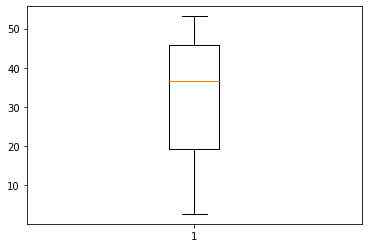

In [41]:
# the distribution of speed
plt.boxplot(df['speed'])

In [42]:
#modify the format for later preprocessing
#datetime.strptime(df.time,%Y%m%d)
df['date']=pd.to_datetime(df['date'],format='%d/%m/%Y %H:%M')


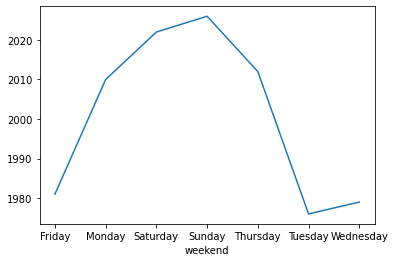

In [43]:
# observe the impact of working day
df['weekend']=df['date'].dt.strftime('%A')
df.groupby(['weekend'])['speed'].count().plot()

#### We could find the influence of working days is significant, so we plot the more specific chart

In [44]:
temp = pd.DatetimeIndex(df['date'])
df['Date']=temp.date
df['Time']=temp.time
df['hours']=temp.hour
df['year']=temp.year
df['month']=temp.month

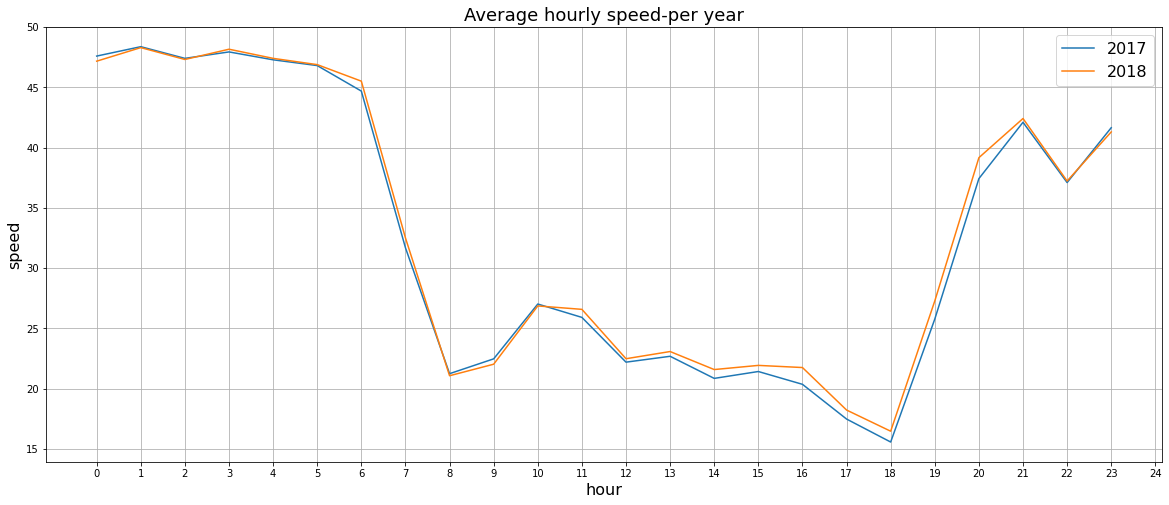

In [45]:
# Average hourly speed analysis
hour_speed_2017 =df[df.year==2017]['speed'].groupby(df['hours']).mean()
hour_speed_2018 =df[df.year==2018]['speed'].groupby(df['hours']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(hour_speed_2017.index,hour_speed_2017.values)
sns.lineplot(hour_speed_2018.index,hour_speed_2018.values)
plt.grid()
plt.xticks(np.arange(0,25,step=1))
plt.legend(['2017','2018'],loc='best',fontsize=16)
plt.title("Average hourly speed-per year",fontsize=18)
plt.ylabel('speed',fontsize=16)
plt.xlabel('hour',fontsize=16)
plt.show()

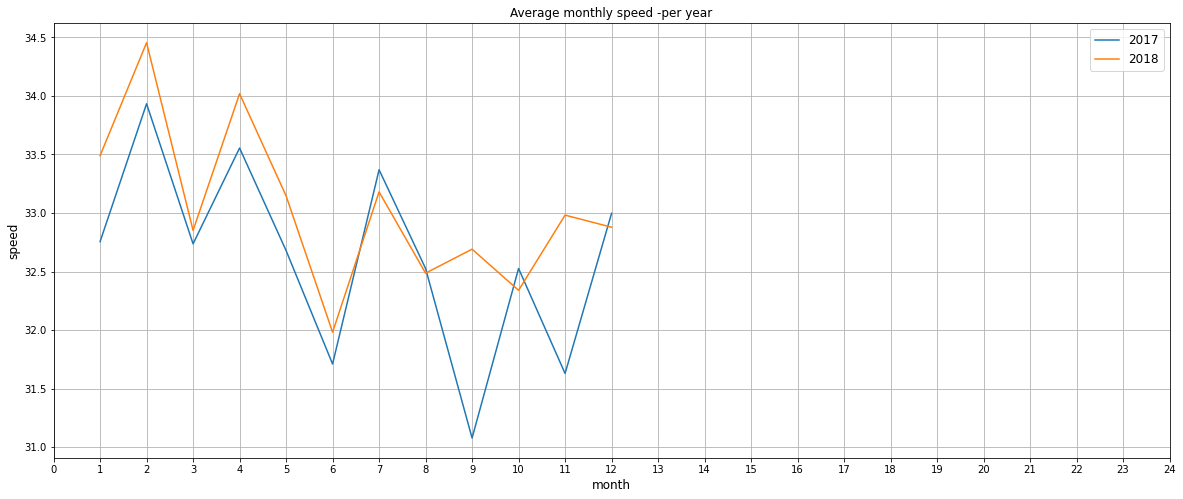

In [46]:
#Average monthly speed analysis
monthly_speed_2017 =df[df.year==2017]['speed'].groupby(df['month']).mean()
monthly_speed_2018 =df[df.year==2018]['speed'].groupby(df['month']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(monthly_speed_2017.index,monthly_speed_2017.values)
sns.lineplot(monthly_speed_2018.index,monthly_speed_2018.values)
plt.grid()
plt.xticks(np.arange(0,25,step=1))
plt.legend(['2017','2018'],loc='best',fontsize=12)
plt.title("Average monthly speed -per year",fontsize=12)
plt.ylabel('speed',fontsize=12)
plt.xlabel('month',fontsize=12)
plt.show()

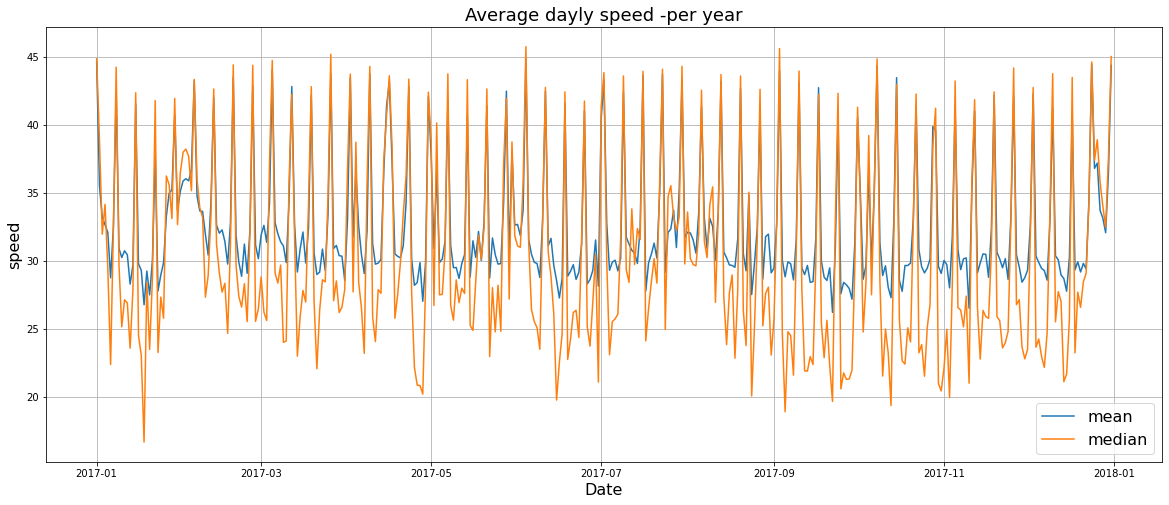

In [47]:
# average dayly speed day analysis
dayly_speed_2017 =df[df.year==2017]['speed'].groupby(df['Date']).mean()
dayly_speed_2018 =df[df.year==2017]['speed'].groupby(df['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(dayly_speed_2017.index,dayly_speed_2017.values)
sns.lineplot(dayly_speed_2018.index,dayly_speed_2018.values)
plt.grid()
#plt.xticks(np.arange(0,,step=1))
plt.legend(['mean','median'],loc='best',fontsize=16)
plt.title("Average dayly speed -per year",fontsize=18)
plt.ylabel('speed',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.show()

#### We could found  the influence of working days and hours is significant, we combine the two features and observe the influence of working days and time combinations.

In [48]:
df['quarter']=df['date'].dt.quarter
df['day_of_month']=df['date'].dt.day
df['week_of_year']=df['date'].dt.weekofyear
df['day_of_year']=df['date'].dt.dayofyear
df['day_of_week']=df['date'].dt.dayofweek+1

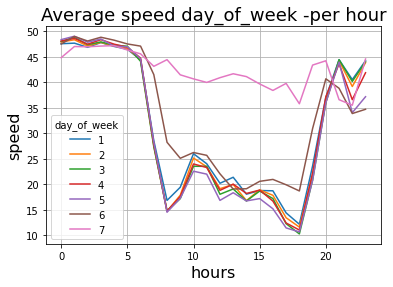

In [49]:
#Average speed day_of_week analysis
df.groupby(['hours', 'day_of_week'])['speed'].mean().unstack().plot()
plt.grid()

plt.title("Average speed day_of_week -per hour",fontsize=18)
plt.ylabel('speed',fontsize=16)
plt.xlabel('hours',fontsize=16)
plt.show()

#### So, we add an feature to combine the weekday and hours in the later feature_function.

###  2.3 fill the missing value and build the features

#### In this part, we bulid the whole date range from 2017 to 2018, and then remove the date existing in the test.csv to get the missing value. 

#### And we utilize the model (XGBoost) we used in the later to fill the missing value.

In [10]:
# get the whole date range
date_range = pd.date_range("2017-01-01 00:00:00", "2018-12-31 20:00:00", freq='1H')
date_range

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2018-12-31 11:00:00', '2018-12-31 12:00:00',
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00'],
              dtype='datetime64[ns]', length=17517, freq='H')

#### The above analysis causes the format to be messy, so we reload the data

In [11]:
df = pd.read_csv("./Data/train.csv",header=0,index_col=0)

In [12]:
test=pd.read_csv("./Data/test.csv",header=0,index_col=0)

In [13]:
df1 = pd.DataFrame(index=date_range).reset_index()
df1['speed'] = None

In [14]:
df1_final = pd.DataFrame({'date':df1['index'], 'speed':df1['speed']})
df1_final['speed']=df1_final['speed'].astype(float)
df1_final

,date,speed
0,2017-01-01 00:00:00,NaN
1,2017-01-01 01:00:00,NaN
2,2017-01-01 02:00:00,NaN
3,2017-01-01 03:00:00,NaN
4,2017-01-01 04:00:00,NaN
...,...,...
17512,2018-12-31 16:00:00,NaN
17513,2018-12-31 17:00:00,NaN
17514,2018-12-31 18:00:00,NaN
17515,2018-12-31 19:00:00,NaN


In [15]:
# utilize the whole date_range join with the train.csv to find the missing value
df['date']=pd.to_datetime(df['date'],format='%d/%m/%Y %H:%M')
df2 = pd.merge(df1_final, df, on=['date'], how='left')
df2


,date,speed_x,speed_y
0,2017-01-01 00:00:00,NaN,43.002930
1,2017-01-01 01:00:00,NaN,46.118696
2,2017-01-01 02:00:00,NaN,44.294158
3,2017-01-01 03:00:00,NaN,41.067468
4,2017-01-01 04:00:00,NaN,46.448653
...,...,...,...
17512,2018-12-31 16:00:00,NaN,12.501851
17513,2018-12-31 17:00:00,NaN,NaN
17514,2018-12-31 18:00:00,NaN,15.979319
17515,2018-12-31 19:00:00,NaN,NaN


In [16]:
#remove the data existing in the test.csv
df2 = pd.DataFrame({'date':df2['date'], 'speed':df2['speed_y']})
test['date']=pd.to_datetime(test['date'],format='%d/%m/%Y %H:%M')
df2_filter = df2[~ df2['date'].isin(test['date'])]
df2_filter

,date,speed
0,2017-01-01 00:00:00,43.002930
1,2017-01-01 01:00:00,46.118696
2,2017-01-01 02:00:00,44.294158
3,2017-01-01 03:00:00,41.067468
4,2017-01-01 04:00:00,46.448653
...,...,...
17508,2018-12-31 12:00:00,19.865269
17511,2018-12-31 15:00:00,17.820375
17512,2018-12-31 16:00:00,12.501851
17514,2018-12-31 18:00:00,15.979319


In [17]:
# we could find the number of missing value is 10
df2_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14016 entries, 0 to 17516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    14016 non-null  datetime64[ns]
 1   speed   14006 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 328.5 KB


#### besides the above analysis, we will add another feature:
- vacation, rainy day. all the resources from the google.

In [18]:
#creat the build feature functions
def f_features(df,label=None):
    
    df['date']=pd.to_datetime(df['date'],format='%d/%m/%Y %H:%M')
    
    temp = pd.DatetimeIndex(df['date'])    
    df['Date']=temp.date
    df['year']=temp.year
    df['month']=temp.month
    df['hours']=temp.hour
    
    df['quarter']=df['date'].dt.quarter 
    df['week_of_year']=df['date'].dt.weekofyear
    df['day_of_year']=df['date'].dt.dayofyear
    df['day_of_month']=df['date'].dt.day
    df['day_of_week']=df['date'].dt.dayofweek+1
    
    # the combined feature about the weekdays and the hours 
    df.loc[df['day_of_week'].isin([1, 2, 3,4,5]), 'day_of_week_en'] = 1    
    df.loc[df['day_of_week'].isin([6]), 'day_of_week_en'] = 2
    df.loc[df['day_of_week'].isin([7]), 'day_of_week_en'] = 3

    df.loc[df['hours'].isin([0,1,2,3,4,5,6,19,20,21,22,23]), 'hour_en'] = 1
    df.loc[df['hours'].isin([7,8,9,10,11,12,13,14,15,16,17,18]), 'hour_en'] = 2

    # vacation
    df['Date']=df['Date'].astype(str)
    df.loc[df['Date'].isin(
    ['2017-01-01', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-05-01',
     '2017-05-30', '2017-07-01', '2017-10-1','2017-10-05','2017-10-28','2017-12-25','2018-01-01',
     '2018-02-16','2018-02-17','2018-02-19','2018-04-05','2018-05-01','2018-06-18','2018-07-01',
     '2018-09-25','2018-10-01','2018-10-17','2018-12-25']), 'vacation'] = 1

    df.loc[~df['Date'].isin(
    ['2017-01-01', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-05-01',
     '2017-05-30', '2017-07-01', '2017-10-1','2017-10-05','2017-10-28','2017-12-25','2018-01-01',
     '2018-02-16','2018-02-17','2018-02-19','2018-04-05','2018-05-01','2018-06-18','2018-07-01',
     '2018-09-25','2018-10-01','2018-10-17','2018-12-25']), 'vacation'] = 0
    
    
    df['Date1']=df['Date'].astype(str)
    #rainy day
#     df.loc[df['Date1'].isin(
#     ['2017-01-14', '2017-01-15', '2017-01-29', '2017-01-30','2017-02-04', '2017-02-05','2017-02-21','2017-02-22',
#      '2017-05-01','2017-05-30', '2017-06-13','2017-06-17','2017-06-21','2017-07-17','2017-07-18','2017-07-23','2017-08-03',
#      '2017-08-23','2017-08-27','2017-08-28','2017-09-03','2017-09-04','2017-09-09','2017-09-22','2017-09-23','2017-09-30','2017-10-15','2017-10-16','2017-10-17','2017-11-12','2017-11-13','2018-01-07','2018-01-08','2018-01-09','2018-01-31','2018-02-22','2018-02-23','2018-03-08','2018-04-15',
#      '2018-04-24','2018-05-08','2018-05-10','2018-06-06','2018-06-07','2018-06-08','2018-06-12','2018-06-13','2018-06-22','2018-06-23','2018-07-13','2018-07-14','2018-07-15','2018-07-18','2018-07-23','2018-08-10','2018-08-11','2018-08-14','2018-08-17','2018-08-19','2018-08-20','2018-08-26',
#      '2018-08-27','2018-08-28','2018-08-29','2018-09-16','2018-09-24','2018-10-10','2018-10-15','2018-11-03','2018-11-25','2018-11-26', '2018-11-27','2018-11-28','2018-12-23']), 'rainy'] = 1
    
#     df.loc[~df['Date1'].isin(
#     ['2017-01-14', '2017-01-15', '2017-01-29', '2017-01-30','2017-02-04', '2017-02-05','2017-02-21','2017-02-22',
#      '2017-05-01','2017-05-30', '2017-06-13','2017-06-17','2017-06-21','2017-07-17','2017-07-18','2017-07-23','2017-08-03',
#      '2017-08-23','2017-08-27','2017-08-28','2017-09-03','2017-09-04','2017-09-09','2017-09-22','2017-09-23','2017-09-30','2017-10-15','2017-10-16','2017-10-17','2017-11-12','2017-11-13','2018-01-07','2018-01-08','2018-01-09','2018-01-31','2018-02-22','2018-02-23','2018-03-08','2018-04-15',
#      '2018-04-24','2018-05-08','2018-05-10','2018-06-06','2018-06-07','2018-06-08','2018-06-12','2018-06-13','2018-06-22','2018-06-23','2018-07-13','2018-07-14','2018-07-15','2018-07-18','2018-07-23','2018-08-10','2018-08-11','2018-08-14','2018-08-17','2018-08-19','2018-08-20','2018-08-26',
#      '2018-08-27','2018-08-28','2018-08-29','2018-09-16','2018-09-24','2018-10-10','2018-10-15','2018-11-03','2018-11-25','2018-11-26', '2018-11-27','2018-11-28','2018-12-23']), 'rainy'] = 0
    
    X = df[['year', 'month', 'quarter','hours', 'week_of_year', 'day_of_year', 'day_of_month',
            'day_of_week','hour_en','day_of_week_en','vacation','speed']]
    if label:
        y = df[label]
        return X, y
    return X

# training dataset
X, y = f_features(df2_filter, label='speed')

In [19]:
# oberserve the cleaned data
X.columns

Index(['year', 'month', 'quarter', 'hours', 'week_of_year', 'day_of_year',
       'day_of_month', 'day_of_week', 'hour_en', 'day_of_week_en', 'vacation',
       'speed'],
      dtype='object')

In [20]:
X

,year,month,quarter,hours,week_of_year,day_of_year,day_of_month,day_of_week,hour_en,day_of_week_en,vacation,speed
0,2017,1,1,0,52,1,1,7,1.0,3.0,1.0,43.002930
1,2017,1,1,1,52,1,1,7,1.0,3.0,1.0,46.118696
2,2017,1,1,2,52,1,1,7,1.0,3.0,1.0,44.294158
3,2017,1,1,3,52,1,1,7,1.0,3.0,1.0,41.067468
4,2017,1,1,4,52,1,1,7,1.0,3.0,1.0,46.448653
...,...,...,...,...,...,...,...,...,...,...,...,...
17508,2018,12,4,12,1,365,31,1,2.0,1.0,0.0,19.865269
17511,2018,12,4,15,1,365,31,1,2.0,1.0,0.0,17.820375
17512,2018,12,4,16,1,365,31,1,2.0,1.0,0.0,12.501851
17514,2018,12,4,18,1,365,31,1,2.0,1.0,0.0,15.979319


In [21]:
# filling the missing value for speed in the training data

def fill_f(df):
    feature = df.columns.values.tolist()
    train_df = df.loc[~df['speed'].isnull()]
    test_df = df.loc[df['speed'].isnull()].copy()


    train_feature = [x for x in feature if
                     x in ['year', 'month', 'quarter','hours', 'week_of_year', 'day_of_year', 'day_of_month',
            'day_of_week','hour_en','day_of_week_en','vacation' ]]


    print(train_feature)
    X = train_df[train_feature]

    y = train_df['speed']
    test_pre=test_df[train_feature]

    eval_set = [(X, y)]
    
    #the parameters is from the tuning in the later chapter
    other_params={'n_estimators':1000,'learning_rate':0.08,'max_depth':19,'min_child_weight':2,
                             'subsample' :0.8,
                             'colsample_bytree':1,
                             'gamma':0.03,
                             'reg_alpha':12}
    regressor = xgb.XGBRegressor(**other_params,seed=0)
    regressor.fit(X, y, verbose=True, early_stopping_rounds=50, eval_set=eval_set)

    a = regressor.predict(test_pre)

    df.loc[df['speed'].isnull(),'speed']=a

fill_f(X)

['year', 'month', 'quarter', 'hours', 'week_of_year', 'day_of_year', 'day_of_month', 'day_of_week', 'hour_en', 'day_of_week_en', 'vacation']
[0]	validation_0-rmse:32.26503
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:29.73487
[2]	validation_0-rmse:27.41064
[3]	validation_0-rmse:25.27541
[4]	validation_0-rmse:23.31435
[5]	validation_0-rmse:21.51430
[6]	validation_0-rmse:19.86373
[7]	validation_0-rmse:18.34541
[8]	validation_0-rmse:16.95937
[9]	validation_0-rmse:15.68536
[10]	validation_0-rmse:14.51704
[11]	validation_0-rmse:13.45165
[12]	validation_0-rmse:12.47053
[13]	validation_0-rmse:11.57541
[14]	validation_0-rmse:10.75488
[15]	validation_0-rmse:10.00867
[16]	validation_0-rmse:9.32733
[17]	validation_0-rmse:8.70322
[18]	validation_0-rmse:8.13390
[19]	validation_0-rmse:7.61959
[20]	validation_0-rmse:7.14868
[21]	validation_0-rmse:6.72278
[22]	validation_0-rmse:6.33149
[23]	validation_0-rmse:5.98183
[24]	validation_0-rmse:5.66760
[25]	validati

[253]	validation_0-rmse:1.72484
[254]	validation_0-rmse:1.72330
[255]	validation_0-rmse:1.72215
[256]	validation_0-rmse:1.72114
[257]	validation_0-rmse:1.71955
[258]	validation_0-rmse:1.71857
[259]	validation_0-rmse:1.71736
[260]	validation_0-rmse:1.71633
[261]	validation_0-rmse:1.71548
[262]	validation_0-rmse:1.71434
[263]	validation_0-rmse:1.71312
[264]	validation_0-rmse:1.71226
[265]	validation_0-rmse:1.71108
[266]	validation_0-rmse:1.70995
[267]	validation_0-rmse:1.70889
[268]	validation_0-rmse:1.70799
[269]	validation_0-rmse:1.70680
[270]	validation_0-rmse:1.70605
[271]	validation_0-rmse:1.70509
[272]	validation_0-rmse:1.70419
[273]	validation_0-rmse:1.70334
[274]	validation_0-rmse:1.70258
[275]	validation_0-rmse:1.70146
[276]	validation_0-rmse:1.70002
[277]	validation_0-rmse:1.69847
[278]	validation_0-rmse:1.69769
[279]	validation_0-rmse:1.69681
[280]	validation_0-rmse:1.69602
[281]	validation_0-rmse:1.69519
[282]	validation_0-rmse:1.69428
[283]	validation_0-rmse:1.69347
[284]	va

[510]	validation_0-rmse:1.54972
[511]	validation_0-rmse:1.54947
[512]	validation_0-rmse:1.54902
[513]	validation_0-rmse:1.54879
[514]	validation_0-rmse:1.54839
[515]	validation_0-rmse:1.54789
[516]	validation_0-rmse:1.54736
[517]	validation_0-rmse:1.54694
[518]	validation_0-rmse:1.54658
[519]	validation_0-rmse:1.54625
[520]	validation_0-rmse:1.54586
[521]	validation_0-rmse:1.54522
[522]	validation_0-rmse:1.54494
[523]	validation_0-rmse:1.54442
[524]	validation_0-rmse:1.54401
[525]	validation_0-rmse:1.54371
[526]	validation_0-rmse:1.54327
[527]	validation_0-rmse:1.54265
[528]	validation_0-rmse:1.54236
[529]	validation_0-rmse:1.54204
[530]	validation_0-rmse:1.54166
[531]	validation_0-rmse:1.54129
[532]	validation_0-rmse:1.54078
[533]	validation_0-rmse:1.54055
[534]	validation_0-rmse:1.54037
[535]	validation_0-rmse:1.53982
[536]	validation_0-rmse:1.53940
[537]	validation_0-rmse:1.53896
[538]	validation_0-rmse:1.53863
[539]	validation_0-rmse:1.53828
[540]	validation_0-rmse:1.53778
[541]	va

[767]	validation_0-rmse:1.46520
[768]	validation_0-rmse:1.46498
[769]	validation_0-rmse:1.46484
[770]	validation_0-rmse:1.46458
[771]	validation_0-rmse:1.46435
[772]	validation_0-rmse:1.46396
[773]	validation_0-rmse:1.46364
[774]	validation_0-rmse:1.46349
[775]	validation_0-rmse:1.46325
[776]	validation_0-rmse:1.46296
[777]	validation_0-rmse:1.46261
[778]	validation_0-rmse:1.46236
[779]	validation_0-rmse:1.46213
[780]	validation_0-rmse:1.46193
[781]	validation_0-rmse:1.46169
[782]	validation_0-rmse:1.46147
[783]	validation_0-rmse:1.46125
[784]	validation_0-rmse:1.46097
[785]	validation_0-rmse:1.46056
[786]	validation_0-rmse:1.46031
[787]	validation_0-rmse:1.46003
[788]	validation_0-rmse:1.45985
[789]	validation_0-rmse:1.45954
[790]	validation_0-rmse:1.45917
[791]	validation_0-rmse:1.45888
[792]	validation_0-rmse:1.45858
[793]	validation_0-rmse:1.45845
[794]	validation_0-rmse:1.45826
[795]	validation_0-rmse:1.45807
[796]	validation_0-rmse:1.45791
[797]	validation_0-rmse:1.45770
[798]	va

In [22]:
# check the missing value
X.isnull().any()

year              False
month             False
quarter           False
hours             False
week_of_year      False
day_of_year       False
day_of_month      False
day_of_week       False
hour_en           False
day_of_week_en    False
vacation          False
speed             False
dtype: bool

In [23]:
y=X['speed']

In [24]:
X=X.drop(columns='speed')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14016 entries, 0 to 17516
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            14016 non-null  int64  
 1   month           14016 non-null  int64  
 2   quarter         14016 non-null  int64  
 3   hours           14016 non-null  int64  
 4   week_of_year    14016 non-null  int64  
 5   day_of_year     14016 non-null  int64  
 6   day_of_month    14016 non-null  int64  
 7   day_of_week     14016 non-null  int64  
 8   hour_en         14016 non-null  float64
 9   day_of_week_en  14016 non-null  float64
 10  vacation        14016 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 1.3 MB


#### process the test data similarly

In [25]:
#creat the build feature functions
def f_features(df,label=None):
    
    df['date']=pd.to_datetime(df['date'],format='%d/%m/%Y %H:%M')
    
    temp = pd.DatetimeIndex(df['date'])    
    df['Date']=temp.date
    df['year']=temp.year
    df['month']=temp.month
    df['hours']=temp.hour
    
    df['quarter']=df['date'].dt.quarter 
    df['week_of_year']=df['date'].dt.weekofyear
    df['day_of_year']=df['date'].dt.dayofyear
    df['day_of_month']=df['date'].dt.day
    df['day_of_week']=df['date'].dt.dayofweek+1
    
    # the combined feature about the weekdays and the hours 
    df.loc[df['day_of_week'].isin([1, 2, 3,4,5]), 'day_of_week_en'] = 1    
    df.loc[df['day_of_week'].isin([6]), 'day_of_week_en'] = 2
    df.loc[df['day_of_week'].isin([7]), 'day_of_week_en'] = 3

    df.loc[df['hours'].isin([0,1,2,3,4,5,6,19,20,21,22,23]), 'hour_en'] = 1
    df.loc[df['hours'].isin([7,8,9,10,11,12,13,14,15,16,17,18]), 'hour_en'] = 2

    # vacation
    df['Date']=df['Date'].astype(str)
    df.loc[df['Date'].isin(
    ['2017-01-01', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-05-01',
     '2017-05-30', '2017-07-01', '2017-10-1','2017-10-05','2017-10-28','2017-12-25','2018-01-01',
     '2018-02-16','2018-02-17','2018-02-19','2018-04-05','2018-05-01','2018-06-18','2018-07-01',
     '2018-09-25','2018-10-01','2018-10-17','2018-12-25']), 'vacation'] = 1

    df.loc[~df['Date'].isin(
    ['2017-01-01', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-05-01',
     '2017-05-30', '2017-07-01', '2017-10-1','2017-10-05','2017-10-28','2017-12-25','2018-01-01',
     '2018-02-16','2018-02-17','2018-02-19','2018-04-05','2018-05-01','2018-06-18','2018-07-01',
     '2018-09-25','2018-10-01','2018-10-17','2018-12-25']), 'vacation'] = 0
    
    
    df['Date1']=df['Date'].astype(str)
    #rainy day
#     df.loc[df['Date1'].isin(
#     ['2017-01-14', '2017-01-15', '2017-01-29', '2017-01-30','2017-02-04', '2017-02-05','2017-02-21','2017-02-22',
#      '2017-05-01','2017-05-30', '2017-06-13','2017-06-17','2017-06-21','2017-07-17','2017-07-18','2017-07-23','2017-08-03',
#      '2017-08-23','2017-08-27','2017-08-28','2017-09-03','2017-09-04','2017-09-09','2017-09-22','2017-09-23','2017-09-30','2017-10-15','2017-10-16','2017-10-17','2017-11-12','2017-11-13','2018-01-07','2018-01-08','2018-01-09','2018-01-31','2018-02-22','2018-02-23','2018-03-08','2018-04-15',
#      '2018-04-24','2018-05-08','2018-05-10','2018-06-06','2018-06-07','2018-06-08','2018-06-12','2018-06-13','2018-06-22','2018-06-23','2018-07-13','2018-07-14','2018-07-15','2018-07-18','2018-07-23','2018-08-10','2018-08-11','2018-08-14','2018-08-17','2018-08-19','2018-08-20','2018-08-26',
#      '2018-08-27','2018-08-28','2018-08-29','2018-09-16','2018-09-24','2018-10-10','2018-10-15','2018-11-03','2018-11-25','2018-11-26', '2018-11-27','2018-11-28','2018-12-23']), 'rainy'] = 1
    
#     df.loc[~df['Date1'].isin(
#     ['2017-01-14', '2017-01-15', '2017-01-29', '2017-01-30','2017-02-04', '2017-02-05','2017-02-21','2017-02-22',
#      '2017-05-01','2017-05-30', '2017-06-13','2017-06-17','2017-06-21','2017-07-17','2017-07-18','2017-07-23','2017-08-03',
#      '2017-08-23','2017-08-27','2017-08-28','2017-09-03','2017-09-04','2017-09-09','2017-09-22','2017-09-23','2017-09-30','2017-10-15','2017-10-16','2017-10-17','2017-11-12','2017-11-13','2018-01-07','2018-01-08','2018-01-09','2018-01-31','2018-02-22','2018-02-23','2018-03-08','2018-04-15',
#      '2018-04-24','2018-05-08','2018-05-10','2018-06-06','2018-06-07','2018-06-08','2018-06-12','2018-06-13','2018-06-22','2018-06-23','2018-07-13','2018-07-14','2018-07-15','2018-07-18','2018-07-23','2018-08-10','2018-08-11','2018-08-14','2018-08-17','2018-08-19','2018-08-20','2018-08-26',
#      '2018-08-27','2018-08-28','2018-08-29','2018-09-16','2018-09-24','2018-10-10','2018-10-15','2018-11-03','2018-11-25','2018-11-26', '2018-11-27','2018-11-28','2018-12-23']), 'rainy'] = 0
    
    X = df[['year', 'month', 'quarter','hours', 'week_of_year', 'day_of_year', 'day_of_month',
            'day_of_week','hour_en','day_of_week_en','vacation']]
    if label:
        y = df[label]
        return X, y
    return X

# test dataset
X_test = f_features(test)

In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3504 entries, 0 to 3503
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            3504 non-null   int64  
 1   month           3504 non-null   int64  
 2   quarter         3504 non-null   int64  
 3   hours           3504 non-null   int64  
 4   week_of_year    3504 non-null   int64  
 5   day_of_year     3504 non-null   int64  
 6   day_of_month    3504 non-null   int64  
 7   day_of_week     3504 non-null   int64  
 8   hour_en         3504 non-null   float64
 9   day_of_week_en  3504 non-null   float64
 10  vacation        3504 non-null   float64
dtypes: float64(3), int64(8)
memory usage: 328.5 KB


In [27]:
X_test.isnull().any()

year              False
month             False
quarter           False
hours             False
week_of_year      False
day_of_year       False
day_of_month      False
day_of_week       False
hour_en           False
day_of_week_en    False
vacation          False
dtype: bool

## 3 model fitting and model training

#### We choose the model XGBoost and utilize the cross validation for parameters tuning



### 3.1 model fitting
we use the train_test_split evaluation and K-fold evaluation for tuning, the performance on the train_test_split is better, so I just introduce the train_test_split evaluation

In [28]:
def modelfit(X_train, y_train, X_test):
    
    x_train,x_test,y_tr,y_te = train_test_split(X_train,y_train,test_size=0.1,random_state=42,shuffle=None)
    
    # XGBoost parameters fitting 
    # Each parameter is adjusted following the below order and updated one by one
    
#     other_params=
#     model = xgb.XGBRegressor(**other_params)
    
#     cv_params={'n_estimators':[300,350,400,450,500]}
#     cv_params={'max_depth': [5, 6, 7, 8, 9, 10]}
#     cv_params={'min_child_weight': [1, 3, 5, 6,8,10,12]}
#     cv_params = {'gamma': [0.2, 0.3, 0.4, 0.5, 0.6]}
#     cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9,1]}
#     cv_params = {'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]} 
#     cv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
    cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2,0.3]}
    
    other_params={'base_score':0.3,
    'colsample_bylevel':1,
    'colsample_bytree':0.6,
    'gamma':0.3,
    'learning_rate':0.05,
    'max_delta_step':0,
    'max_depth':6,
    'min_child_weight':12,
    'n_estimators':300,
    'reg_alpha':3,
    'reg_lambda':3,
    'subsample':1

    }

    model=xgb.XGBRegressor(**other_params)

    print(model.get_params())#获取默认参数

    opt=GridSearchCV(model,cv_params,scoring='r2',cv=5)#调参
    opt.fit(X_train,y_train)

    print('optimize is ongoing...')
    print("Best parameters set found on development set:")
    print()
    print('result of each iteration:')
    print(opt.cv_results_['params'])#输出每次运算的结果
    print()
    print(opt.cv_results_['mean_test_score'])
    print()
    print(opt.best_params_)


#### Using the above parameters and Combine the rmse results of the validation set and training set for fine-tuning

[0]	validation_0-rmse:32.25845	validation_1-rmse:32.39128
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:29.73007	validation_1-rmse:29.85982
[2]	validation_0-rmse:27.40687	validation_1-rmse:27.52901
[3]	validation_0-rmse:25.27332	validation_1-rmse:25.39384
[4]	validation_0-rmse:23.31357	validation_1-rmse:23.42763
[5]	validation_0-rmse:21.51589	validation_1-rmse:21.62472
[6]	validation_0-rmse:19.86804	validation_1-rmse:19.97329
[7]	validation_0-rmse:18.35390	validation_1-rmse:18.45252
[8]	validation_0-rmse:16.96450	validation_1-rmse:17.06127
[9]	validation_0-rmse:15.69179	validation_1-rmse:15.78805
[10]	validation_0-rmse:14.52436	validation_1-rmse:14.62019
[11]	validation_0-rmse:13.45419	validation_1-rmse:13.54961
[12]	validation_0-rmse:12.47559	validation_1-rmse:12.57117
[13]	validation_0-rmse:11.58689	validation_1-rmse:11.68429
[14]	validation_0-rmse:1

[140]	validation_0-rmse:1.94805	validation_1-rmse:3.15301
[141]	validation_0-rmse:1.94551	validation_1-rmse:3.15239
[142]	validation_0-rmse:1.94234	validation_1-rmse:3.15164
[143]	validation_0-rmse:1.93997	validation_1-rmse:3.15037
[144]	validation_0-rmse:1.93634	validation_1-rmse:3.15121
[145]	validation_0-rmse:1.93330	validation_1-rmse:3.15036
[146]	validation_0-rmse:1.93060	validation_1-rmse:3.14872
[147]	validation_0-rmse:1.92752	validation_1-rmse:3.14788
[148]	validation_0-rmse:1.92377	validation_1-rmse:3.14724
[149]	validation_0-rmse:1.92105	validation_1-rmse:3.14670
[150]	validation_0-rmse:1.91791	validation_1-rmse:3.14588
[151]	validation_0-rmse:1.91502	validation_1-rmse:3.14592
[152]	validation_0-rmse:1.91258	validation_1-rmse:3.14608
[153]	validation_0-rmse:1.90869	validation_1-rmse:3.14521
[154]	validation_0-rmse:1.90609	validation_1-rmse:3.14584
[155]	validation_0-rmse:1.90339	validation_1-rmse:3.14485
[156]	validation_0-rmse:1.90120	validation_1-rmse:3.14419
[157]	validati

[282]	validation_0-rmse:1.69745	validation_1-rmse:3.14127
[283]	validation_0-rmse:1.69636	validation_1-rmse:3.14065
[284]	validation_0-rmse:1.69536	validation_1-rmse:3.14089
[285]	validation_0-rmse:1.69446	validation_1-rmse:3.14069
[286]	validation_0-rmse:1.69314	validation_1-rmse:3.14040
[287]	validation_0-rmse:1.69241	validation_1-rmse:3.14041
[288]	validation_0-rmse:1.69159	validation_1-rmse:3.14025
[289]	validation_0-rmse:1.69047	validation_1-rmse:3.14015
[290]	validation_0-rmse:1.68954	validation_1-rmse:3.14118
[291]	validation_0-rmse:1.68857	validation_1-rmse:3.14152
[292]	validation_0-rmse:1.68745	validation_1-rmse:3.14128
[293]	validation_0-rmse:1.68620	validation_1-rmse:3.14108
[294]	validation_0-rmse:1.68533	validation_1-rmse:3.14142
[295]	validation_0-rmse:1.68411	validation_1-rmse:3.14206
[296]	validation_0-rmse:1.68294	validation_1-rmse:3.14201
[297]	validation_0-rmse:1.68224	validation_1-rmse:3.14214
[298]	validation_0-rmse:1.68149	validation_1-rmse:3.14248
[299]	validati

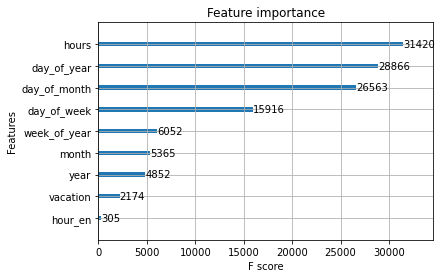

In [29]:
def trainandTest(X_train, y_train, X_test):
    
    x_train,x_test,y_tr,y_te = train_test_split(X_train,y_train,test_size=0.1,random_state=42,shuffle=None)
    
    # XGBoost parameters fitting 
    other_params={'n_estimators':1000,'learning_rate':0.08,'max_depth':19,'min_child_weight':2,
                             'subsample' :0.8,
                             'colsample_bytree':1,
                             'gamma':0.03,
                             'reg_alpha':12

    }

    model=xgb.XGBRegressor(**other_params,seed=0)

    model.fit(x_train, y_tr,eval_set=[(x_train,y_tr),(x_test,y_te)],early_stopping_rounds=100)
    #model.fit(X_train,y_train,eval_set=[(X_train,y_train)],early_stopping_rounds=50)
 
    # visualize the important feature
    plot_importance(model)
    plt.show()
    
trainandTest(X,y,X_test)

### 3.2 model training

#### Use all the train data to feed the model and output the final results

In [31]:
def trainandTest(X_train, y_train, X_test):
    
    x_train,x_test,y_tr,y_te = train_test_split(X_train,y_train,test_size=0.1,random_state=42,shuffle=None)
    
    # XGBoost parameters fitting 
    other_params={'n_estimators':1000,'learning_rate':0.08,'max_depth':19,'min_child_weight':2,
                             'subsample' :0.8,
                             'colsample_bytree':1,
                             'gamma':0.03,
                             'reg_alpha':12

    }

    model=xgb.XGBRegressor(**other_params,seed=0)

    model.fit(X_train,y_train,eval_set=[(X_train,y_train)],early_stopping_rounds=50)
    
    # testing
    y = model.predict(X_test)
    
    
#     # writing to files
    pd_data = pd.DataFrame(y,columns=['speed'])
    final = pd.DataFrame({'id':pd_data.index, 'speed':pd_data['speed']})
    
# #     # print(pd_data)
    final.to_csv('submit.csv', index=None)

trainandTest(X,y,X_test)

[0]	validation_0-rmse:32.27170
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:29.74359
[2]	validation_0-rmse:27.41825
[3]	validation_0-rmse:25.28168
[4]	validation_0-rmse:23.32223
[5]	validation_0-rmse:21.52127
[6]	validation_0-rmse:19.86699
[7]	validation_0-rmse:18.35144
[8]	validation_0-rmse:16.96271
[9]	validation_0-rmse:15.68664
[10]	validation_0-rmse:14.51761
[11]	validation_0-rmse:13.45109
[12]	validation_0-rmse:12.46922
[13]	validation_0-rmse:11.57123
[14]	validation_0-rmse:10.75029
[15]	validation_0-rmse:10.00482
[16]	validation_0-rmse:9.32433
[17]	validation_0-rmse:8.70302
[18]	validation_0-rmse:8.13859
[19]	validation_0-rmse:7.61924
[20]	validation_0-rmse:7.15676
[21]	validation_0-rmse:6.73363
[22]	validation_0-rmse:6.34128
[23]	validation_0-rmse:5.99161
[24]	validation_0-rmse:5.67280
[25]	validation_0-rmse:5.38600
[26]	validation_0-rmse:5.12613
[27]	validation_0-rmse:4.89373
[28]	validation_0-rmse:4.68027
[29]	validation_0-rmse:4.48313

[257]	validation_0-rmse:1.71659
[258]	validation_0-rmse:1.71537
[259]	validation_0-rmse:1.71439
[260]	validation_0-rmse:1.71340
[261]	validation_0-rmse:1.71259
[262]	validation_0-rmse:1.71129
[263]	validation_0-rmse:1.71018
[264]	validation_0-rmse:1.70921
[265]	validation_0-rmse:1.70808
[266]	validation_0-rmse:1.70716
[267]	validation_0-rmse:1.70600
[268]	validation_0-rmse:1.70512
[269]	validation_0-rmse:1.70387
[270]	validation_0-rmse:1.70292
[271]	validation_0-rmse:1.70186
[272]	validation_0-rmse:1.70076
[273]	validation_0-rmse:1.69965
[274]	validation_0-rmse:1.69851
[275]	validation_0-rmse:1.69738
[276]	validation_0-rmse:1.69650
[277]	validation_0-rmse:1.69571
[278]	validation_0-rmse:1.69480
[279]	validation_0-rmse:1.69425
[280]	validation_0-rmse:1.69353
[281]	validation_0-rmse:1.69261
[282]	validation_0-rmse:1.69113
[283]	validation_0-rmse:1.69028
[284]	validation_0-rmse:1.68947
[285]	validation_0-rmse:1.68830
[286]	validation_0-rmse:1.68708
[287]	validation_0-rmse:1.68592
[288]	va

[514]	validation_0-rmse:1.54740
[515]	validation_0-rmse:1.54701
[516]	validation_0-rmse:1.54639
[517]	validation_0-rmse:1.54597
[518]	validation_0-rmse:1.54539
[519]	validation_0-rmse:1.54495
[520]	validation_0-rmse:1.54444
[521]	validation_0-rmse:1.54406
[522]	validation_0-rmse:1.54375
[523]	validation_0-rmse:1.54348
[524]	validation_0-rmse:1.54313
[525]	validation_0-rmse:1.54269
[526]	validation_0-rmse:1.54236
[527]	validation_0-rmse:1.54199
[528]	validation_0-rmse:1.54173
[529]	validation_0-rmse:1.54144
[530]	validation_0-rmse:1.54100
[531]	validation_0-rmse:1.54061
[532]	validation_0-rmse:1.54038
[533]	validation_0-rmse:1.53987
[534]	validation_0-rmse:1.53950
[535]	validation_0-rmse:1.53914
[536]	validation_0-rmse:1.53874
[537]	validation_0-rmse:1.53834
[538]	validation_0-rmse:1.53794
[539]	validation_0-rmse:1.53725
[540]	validation_0-rmse:1.53683
[541]	validation_0-rmse:1.53663
[542]	validation_0-rmse:1.53616
[543]	validation_0-rmse:1.53562
[544]	validation_0-rmse:1.53530
[545]	va

[771]	validation_0-rmse:1.46298
[772]	validation_0-rmse:1.46275
[773]	validation_0-rmse:1.46246
[774]	validation_0-rmse:1.46209
[775]	validation_0-rmse:1.46188
[776]	validation_0-rmse:1.46165
[777]	validation_0-rmse:1.46131
[778]	validation_0-rmse:1.46105
[779]	validation_0-rmse:1.46091
[780]	validation_0-rmse:1.46075
[781]	validation_0-rmse:1.46059
[782]	validation_0-rmse:1.46033
[783]	validation_0-rmse:1.46008
[784]	validation_0-rmse:1.45979
[785]	validation_0-rmse:1.45957
[786]	validation_0-rmse:1.45935
[787]	validation_0-rmse:1.45911
[788]	validation_0-rmse:1.45890
[789]	validation_0-rmse:1.45867
[790]	validation_0-rmse:1.45843
[791]	validation_0-rmse:1.45826
[792]	validation_0-rmse:1.45789
[793]	validation_0-rmse:1.45762
[794]	validation_0-rmse:1.45739
[795]	validation_0-rmse:1.45714
[796]	validation_0-rmse:1.45682
[797]	validation_0-rmse:1.45664
[798]	validation_0-rmse:1.45633
[799]	validation_0-rmse:1.45618
[800]	validation_0-rmse:1.45595
[801]	validation_0-rmse:1.45583
[802]	va